# Showcase of QOSF project — Quantum Twins of Quantum Sensors.

**By:** Juan Javier Naranjo Navarrete, physicist.

**Project directed by:** Dr. Jack Baker

**Objective of the project:** Leverage the shared operational principles between quantum sensors and spin-defect-based quantum computers to create digital twins for advanced modeling, analysis, and optimization of these sensors, focusing on the $NV^{-}$ centers in the diamond.

**Quick Description of the project:** Developed the Python module `NV_HTE_KFF_Module` based on Pennylane to encode the Hamiltonian of multiple $NV^{-}$ centers, incorporating nuclear interactions, lattice vibrations, dipole-dipole coupling, and 14N impurities. Simulated the time evolution using optimized higher-order product formulas and implemented a fast-forwarding methods for long timescales.

**Important:** Due to a Non-Disclosure Agreement, the module `NV_HTE_KFF_Module` cannot be shared. This notebook was compiled sequentially. This project is currently implementing and improving the fast-forwarding methods.

## Importing packages and defining useful functions.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# the following module contains all functions and objects from the project.
from NV_HTE_KFF_Module import *

The following cell contains several functions to be used throughout this notebook. Each function contains its docstring to be easily understood and modified if required.

In [2]:
def initial_state_from_string(spin_wires, states):
    """
    Circuit that sets the initial state of the electronic spins onto the wires encoding those.
    Parameters:
        spin_wires(list[list[int]]) : list containing the pairs of wires, as lists as well, where the spin-1 is encoded.
        states(list[str]) : list containing the initial state of the spins. Could be 'GHZ' for a state of the form |000...> + |222...>,
                        'superposition' for a Hadamard-wise superposition, 'excited' for |2> state, or an arbitrary binary state.
    Returns:
        None
    """

    if (states == "GHZ"):
        assert len(spin_wires)>1, "GHZ state needs more than 1 electronic spin."
        qml.Hadamard(wires = spin_wires[0][0])
        for i in range(len(spin_wires)-1):
            qml.CNOT(wires = [spin_wires[i][0], spin_wires[i+1][0]])
    else:
        assert len(spin_wires)==len(states), "Number of pairs of wires must be equal to number of states."
        for sw, state in zip(spin_wires, states):
            if state == "excited":
                qml.PauliX(wires = sw[0])
            elif state == "superposition":
                qml.Hadamard(wires = sw[0])

def onsite_bosons(wires, state):
    """
    Circuit that sets the initial state of the bosonic bath onto the wires encoding it.
    Parameters:
        wires(list[int]) : list containing the wires where the bosonic bath is encoded.
        state(str) : initial state of the bosonic bath. Could be 'superposition' for a Hadamard-wise superposition,
                        an arbitrary binary state, or 'random' for a random state contructed using RX gates.
    Returns:
        None
    """

    if state == "superposition":
        for wire in wires:
            qml.Hadamard(wire)
    elif state == "random":
        for wire,num in zip(wires, np.random.random((len(wires),))):
            qml.RX(2*np.pi*num, wires = wire)
    else:
        for wire,st in zip(wires, state):
            assert (st=="0") or (st=="1"), f"Invalid value for bit: {st}"
            if st == "1":
                qml.PauliX(wire)

def circuit_resources(H_obj, time, order, steps, grouping):
    """
    Function that returns the resources and depth of the quantum circuit encodes the trotterization of the Hamiltonian.
    Parameters.
        H_obj(Many_NVs_Hamiltonian) : object from the class 'Many_NVs_Hamiltonian'.
        time(float) : time to evolve the system.
        order(int) : order of the Trotterization.
        steps(int) : number of steps of the Trotterization.
        grouping(bool) : whether or not to apply the wrapper 'remove_adjoint_operations' to the quantum circuit so the optimization layer is applied.
    Returns:
        tuple[dict, int]
    """

    dev = qml.devices.NullQubit(wires = H_obj.info_wires[2])
    @qml.qnode(dev, interface=None, diff_method=None)
    def circuit():
        initial_state_from_string(H_obj.spin_wires, ["superposition"]*len(H_obj.spin_wires))
        onsite_bosons(H_obj.boson_wires, "superposition")
        Hamiltonian_Trotterization(H_obj, time, order//2, steps)
        return qml.probs()

    if grouping:
        # remove_adjoint_operations can be applied as a decorator as well
        circuit = remove_adjoint_operations(circuit)

    specs = qml.specs(circuit)()
    return dict(specs['resources'].gate_sizes), specs['resources'].depth

def Boson_Hamiltonian(H_obj):
    """
    Function that returns the Hamiltonian of the bosonic bath.
    Parameters:
        H_obj(Many_NVs_Hamiltonian) : object from the class 'Many_NVs_Hamiltonian'.
    Returns:
        PennyLane Operator
    """

    return qml.dot(*boson_hamiltonian(H_obj.omega, H_obj.current_number_bosons, H_obj.boson_wires))

def time_evolution(H_obj, order, steps, spins_init_state, boson_init_state, device = "lightning.qubit"):
    """
    Function that returns a qnode with the time evolution of the system as argument.
    Parameters:
        H_obj(Many_NVs_Hamiltonian) : object from the class 'Many_NVs_Hamiltonian'.
        order(int) : order of the Trotterization.
        steps(int) : number of steps of the Trotterization.
        spins_init_state(list[str],str) : list containing the initial state of the spins. Could be 'GHZ' for a state of the form |000...> + |222...>,
                        'superposition' for a Hadamard-wise superposition, 'excited' for |2> state, or an arbitrary binary state.
        boson_init_state(str) : initial state of the bosonic bath. Could be 'superposition' for a Hadamard-wise superposition,
                        an arbitrary binary state, or 'random' for a random state contructed using RX gates.
        device(str) : name of the device to use for the qnode. Default is 'lightning.qubit'.
    Returns:
        qml.QNode
    """

    dev = qml.device(device, wires = sorted(H_obj.info_wires[2]))

    @remove_adjoint_operations
    @qml.qnode(dev)
    def evolution(time):
        initial_state_from_string(H_obj.spin_wires, spins_init_state)
        onsite_bosons(H_obj.boson_wires, boson_init_state)
        Hamiltonian_Trotterization(H_obj, time, order//2, steps)
        gray_to_bin(H_obj.boson_wires)
        return qml.probs(wires = sum(H_obj.spin_wires,[])), qml.expval(qml.dot(*H_obj.raw_H())), qml.expval(Boson_Hamiltonian(H_obj))

    return evolution

## Resource estimations

Let's start by defining an instance of the backbone of this project: the `Many_NVs_Hamiltonian` class; a dynamical object that stores and returns the wide majority of needed data we will use throughout this notebook. It assumes a magnetic field aligned with the z-axis. Here is a quick explanation of its inputs.

- `Bz`: intensity of magnetic field in teslas [T].
- `number_NV_spins`: initial number of electronic spins, or $NV^{-}$ centers.
- `distances_NV_spins`: distances between electronic spins in angstroms [A]. Notice there should be $N\times (N-1)/2$ 3-elements lists, with $N$ the number of electronic spins.
- `number_bosons`: maximum number of bosons coupled to the system.
- `omega`: vibration frequency of bosons in hertz [Hz].
- `coupling_constant`: coupling intensity between electronic spins and bosons in hertz [Hz].
- `spin_coupling_term`: Gray-encoded operator applied to the electronic spins that couples these with the bosonic bath.

In [3]:
Hamiltonian = Many_NVs_Hamiltonian(Bz = 0.1,
                                   number_NV_spins = 4,
                                   distances_NV_spins = [[1,0,0],[0,0,1],[1,0,1], # 0 -> 1 | 0 -> 2 | 0 -> 3
                                                         [0,0,1], [-1,0,1], # 1 -> 2 | # 1 -> 3
                                                         [-1,0,0]], # 2 -> 3
                                   number_bosons = 3,
                                   omega = 5.8e9,
                                   coupling_constant = 1.78e9,
                                   spin_coupling_term = [np.sqrt(2)*0.25*np.array([1,1,1,-1]),
                                                         ["IX","ZX","XI","XZ"]]) # spin-1 X Pauli operator

The current `Hamiltonian` instance has 4 NV centers arranged in a 1x1 angstrom square onto the XZ plane. Distances are added resembling relative positions of the NV centers.

Here is a quick view and explanation of the items and functions of this instance.

In [4]:
# add_14N_impurity function to add a 14N impurity
# placing placing an impurity on the center of the square
Hamiltonian.add_14N_impurity([[0.5,0,0.5], # distance from 1st NV center
                             [-0.5,0,0.5], # distance from 2nd NV center
                             [-0.5,0,-0.5], # distance from 3rd NV center
                             [0.5,0,-0.5]]) # distance from 4th NV center

In [5]:
# raw_H to calculate the complete hamiltonian operator as a Pennylane operator
for i, (coef, op) in enumerate(zip(*Hamiltonian.raw_H())):
    print(f"Term {i+1}", coef, op, sep = "\t")
    if i > 12:
        break

Term 1	1435000000.0	I()
Term 2	1435000000.0	Z(0) @ Z(1)
Term 3	8807374876.18347	Z(0)
Term 4	8807374876.18347	Z(1)
Term 5	133100.48222895467	Z(8)
Term 6	1799767.1488956213	Z(9)
Term 7	-540000.0	Z(0) @ Z(8)
Term 8	-540000.0	Z(0) @ Z(9)
Term 9	-540000.0	Z(1) @ Z(8)
Term 10	-540000.0	Z(1) @ Z(9)
Term 11	-337500.0	X(1) @ X(9)
Term 12	-337500.0	Z(8) @ X(9) @ X(1)
Term 13	-337500.0	X(1) @ X(8)
Term 14	337500.0	X(8) @ Z(9) @ X(1)


Next is the function that allows us to implement an optimization layer by grouping qubit-wise commuting terms. This reduces the gate number and the depth of the circuits as adjoint operations are canceled.

In [6]:
# H_as_comm_groups to group the qubit-wise commuting terms
# here we are printing the first commuting group
for i, (coef, op) in enumerate(zip(*Hamiltonian.H_as_comm_groups()[0])):
    print(f"Term {i+1}", coef, op, sep = "\t")
    if i > 12:
        break

Term 1	8807374876.18347	ZIIIIIIIIIIIIIIIIIII
Term 2	133100.48222895467	IIIIIIIIZIIIIIIIIIII
Term 3	-540000.0	ZIIIIIIIZIIIIIIIIIII
Term 4	12694194.858760476	IIIIIYIIIIIIIIIIIIIY
Term 5	12694194.858760476	IIIIIYIIIIIIIIIIIIZY
Term 6	-337500.0	IYIIIIIIZYIIIIIIIIII
Term 7	-337500.0	IYIIIIIIIYIIIIIIIIII
Term 8	12694194.858760476	IIIIZYIIIIIIIIIIIIIY
Term 9	12694194.858760476	IIIIZYIIIIIIIIIIIIZY
Term 10	-337500.0	ZYIIIIIIIYIIIIIIIIII
Term 11	-337500.0	ZYIIIIIIZYIIIIIIIIII
Term 12	-12694194.858760469	IIIIZIIIIIIIIIIIIIZI
Term 13	8807374876.18347	IIZIIIIIIIIIIIIIIIII
Term 14	133100.48222895467	IIIIIIIIIIZIIIIIIIII


In [7]:
# an overview of the items
for name, value in zip(("Intensitity of magnetic field", "Current number of NV centers", "Distances between NV spins", "Wires where NV centers are encoded",
                        "Wires where NV centers' nuclear spins are encoded", "Bosons vibration frequency", "Current number of maximum bosons", "Wires where the boson bath state is encoded",
                        "Wires where 14N impurities spins are encoded", "Coupling intensity with the boson bath", "Gray-encoded coupling operator", "Maximum wire, Number of wires, wires"),
                        (Hamiltonian.Bz, Hamiltonian.current_number_NV_spins, Hamiltonian.distances_NV_spins, Hamiltonian.spin_wires,
                        Hamiltonian.nuclear_spin_wires, Hamiltonian.omega, Hamiltonian.current_number_bosons, Hamiltonian.boson_wires,
                        Hamiltonian.N14_impurities_wires, Hamiltonian.coupling_constant, Hamiltonian.spin_coupling_term, Hamiltonian.info_wires)):
    print(name, value, sep = " : ")

Intensitity of magnetic field : 0.1
Current number of NV centers : 4
Distances between NV spins : [[1, 0, 0], [0, 0, 1], [1, 0, 1], [0, 0, 1], [-1, 0, 1], [-1, 0, 0]]
Wires where NV centers are encoded : [[0, 1], [2, 3], [4, 5], [6, 7]]
Wires where NV centers' nuclear spins are encoded : [[8, 9], [10, 11], [12, 13], [14, 15]]
Bosons vibration frequency : 5800000000.0
Current number of maximum bosons : 3
Wires where the boson bath state is encoded : [16, 17]
Wires where 14N impurities spins are encoded : [[18, 19]]
Coupling intensity with the boson bath : 1780000000.0
Gray-encoded coupling operator : [tensor([ 0.35355339,  0.35355339,  0.35355339, -0.35355339], requires_grad=True), ['IX', 'ZX', 'XI', 'XZ']]
Maximum wire, Number of wires, wires : (19, 20, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 16, 17])


Let's work with the simplest model: 1 NV center, no impurities, and upto 3 bosons. We can reset our `Hamiltonian` instance just by setting the current number of NV centers to 1.

In [8]:
Hamiltonian.current_number_NV_spins = 1
for name, value in zip(("Intensitity of magnetic field", "Current number of NV centers", "Distances between NV spins", "Wires where NV centers are encoded",
                        "Wires where NV centers' nuclear spins are encoded", "Bosons vibration frequency", "Current number of maximum bosons", "Wires where the boson bath state is encoded",
                        "Wires where 14N impurities spins are encoded", "Coupling intensity with the boson bath", "Gray-encoded coupling operator", "Maximum wire, Number of wires, wires"),
                        (Hamiltonian.Bz, Hamiltonian.current_number_NV_spins, Hamiltonian.distances_NV_spins, Hamiltonian.spin_wires,
                        Hamiltonian.nuclear_spin_wires, Hamiltonian.omega, Hamiltonian.current_number_bosons, Hamiltonian.boson_wires,
                        Hamiltonian.N14_impurities_wires, Hamiltonian.coupling_constant, Hamiltonian.spin_coupling_term, Hamiltonian.info_wires)):
    print(name, value, sep = " : ")

Intensitity of magnetic field : 0.1
Current number of NV centers : 1
Distances between NV spins : []
Wires where NV centers are encoded : [[0, 1]]
Wires where NV centers' nuclear spins are encoded : [[2, 3]]
Bosons vibration frequency : 5800000000.0
Current number of maximum bosons : 3
Wires where the boson bath state is encoded : [4, 5]
Wires where 14N impurities spins are encoded : []
Coupling intensity with the boson bath : 1780000000.0
Gray-encoded coupling operator : [tensor([ 0.35355339,  0.35355339,  0.35355339, -0.35355339], requires_grad=True), ['IX', 'ZX', 'XI', 'XZ']]
Maximum wire, Number of wires, wires : (5, 6, [0, 1, 2, 3, 4, 5])


Next, let's calculate the trotter error of a 10-steps implementation with the second order formula and up to 10 picoseconds. The following function uses the formula

$$ɛ = exp\left( \frac{(t||H||)^{n+1}}{r^{n}} \right)$$

to calculate the error $ɛ$, where $||H||$ is the Hamiltonian's 1-norm, $t$ is the time, $r$ is the number of steps, and $n$ is the order of trotterization.

In [9]:
Trotter_error(Operator = Hamiltonian, time = 10e-12, order = 2, steps = 10)

0.0009620664990183027

Now, knowing that the error is low, therefore this time is reachable with 10 trotter steps, let's estimate the number of T and CNOT gates as well as the circuit's depth to implement this time evolution by trotterization.

### As the number of bosons increases.


Finished estimations with 3 maximum number of bosons.
Without grouping : Number of T gates = 212868, Number of CNOT gates = 3925, Depth = 7223
With grouping : Number of T gates = 67068, Number of CNOT gates = 2927, Depth = 4089

Finished estimations with 7 maximum number of bosons.
Without grouping : Number of T gates = 321984, Number of CNOT gates = 7166, Depth = 12083
With grouping : Number of T gates = 96264, Number of CNOT gates = 4668, Depth = 6399

Finished estimations with 15 maximum number of bosons.
Without grouping : Number of T gates = 596340, Number of CNOT gates = 17287, Depth = 26643
With grouping : Number of T gates = 153828, Number of CNOT gates = 9289, Depth = 12449

Finished estimations with 31 maximum number of bosons.
Without grouping : Number of T gates = 1259496, Number of CNOT gates = 45608, Depth = 65843
With grouping : Number of T gates = 289944, Number of CNOT gates = 18590, Depth = 25399

Finished estimations with 63 maximum number of bosons.
Without groupin

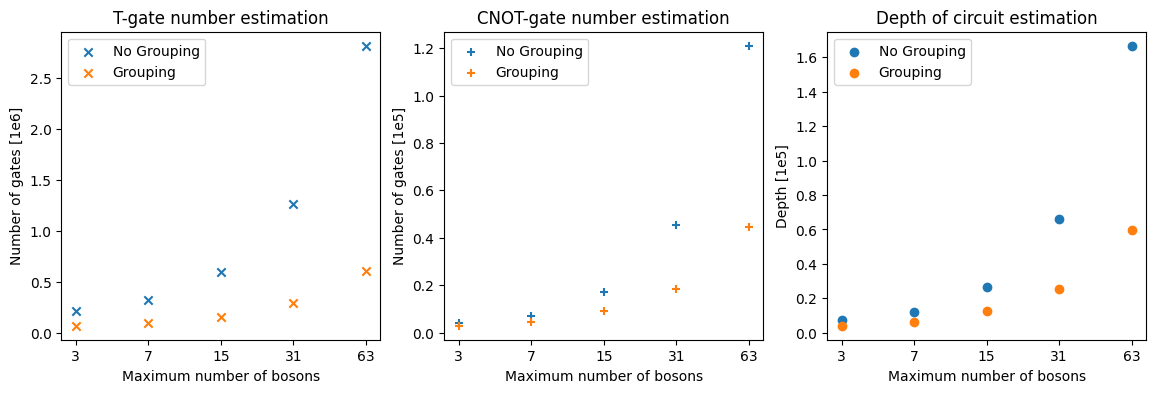

In [10]:
n_bosons = [3,7,15,31,63]
gates_group = {"T" : [], "CNOT" : []}
gates_no_group = {"T" : [], "CNOT" : []}
depth_group = []
depth_no_group = []

for i, nb in enumerate(n_bosons):
    Hamiltonian.current_number_bosons = nb # change number of maximum bosons
    gates, depth = circuit_resources(H_obj = Hamiltonian, time = 1e-12, order = 2, steps = 10, grouping = False)
    gates_no_group["T"].append(gates[1]*36) # factor from formula ceil(1.149 * math.log(1 / 1e-10) + 9.2) for T gates estimations
    gates_no_group["CNOT"].append(gates[2])
    depth_no_group.append(depth)
    gates, depth = circuit_resources(H_obj = Hamiltonian, time = 1e-12, order = 2, steps = 10, grouping = True)
    gates_group["T"].append(gates[1]*36) # factor from formula ceil(1.149 * math.log(1 / 1e-10) + 9.2) for T gates estimations
    gates_group["CNOT"].append(gates[2])
    depth_group.append(depth)
    print(f"\nFinished estimations with {nb} maximum number of bosons.")
    print(f"Without grouping : Number of T gates = {gates_no_group['T'][i]}, Number of CNOT gates = {gates_no_group['CNOT'][i]}, Depth = {depth_no_group[i]}")
    print(f"With grouping : Number of T gates = {gates_group['T'][i]}, Number of CNOT gates = {gates_group['CNOT'][i]}, Depth = {depth_group[i]}")

# constructing figure
fig, axs = plt.subplots(1, 3, figsize = (14,4))
axs[0].scatter(range(len(n_bosons)), 1e-6*np.array(gates_no_group["T"]), marker = "x", label = "No Grouping")
axs[0].scatter(range(len(n_bosons)), 1e-6*np.array(gates_group["T"]), marker = "x", label = "Grouping")
axs[1].scatter(range(len(n_bosons)), 1e-5*np.array(gates_no_group["CNOT"]), marker = "+", label = "No Grouping")
axs[1].scatter(range(len(n_bosons)), 1e-5*np.array(gates_group["CNOT"]), marker = "+", label = "Grouping")
axs[2].scatter(range(len(n_bosons)), 1e-5*np.array(depth_no_group), marker = "o", label = "No Grouping")
axs[2].scatter(range(len(n_bosons)), 1e-5*np.array(depth_group), marker = "o", label = "Grouping")
axs[0].set(xlabel = "Maximum number of bosons", ylabel = "Number of gates [1e6]", title = "T-gate number estimation", xticks = range(len(n_bosons)), xticklabels = n_bosons)
axs[1].set(xlabel = "Maximum number of bosons", ylabel = "Number of gates [1e5]", title = "CNOT-gate number estimation", xticks = range(len(n_bosons)), xticklabels = n_bosons)
axs[2].set(xlabel = "Maximum number of bosons", ylabel = "Depth [1e5]", title = "Depth of circuit estimation", xticks = range(len(n_bosons)), xticklabels = n_bosons)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.show()

### As the number of 14N impurities increases.



Finished estimations with 0 impurities.
Without grouping : Number of T gates = 212868, Number of CNOT gates = 3925, Depth = 7223
With grouping : Number of T gates = 67068, Number of CNOT gates = 2927, Depth = 4089

Finished estimations with 1 impurities.
Without grouping : Number of T gates = 450468, Number of CNOT gates = 8127, Depth = 14963
With grouping : Number of T gates = 119484, Number of CNOT gates = 5965, Depth = 7922

Finished estimations with 2 impurities.
Without grouping : Number of T gates = 688428, Number of CNOT gates = 12209, Depth = 21583
With grouping : Number of T gates = 179820, Number of CNOT gates = 8953, Depth = 10821

Finished estimations with 3 impurities.
Without grouping : Number of T gates = 926028, Number of CNOT gates = 16411, Depth = 29193
With grouping : Number of T gates = 218052, Number of CNOT gates = 11733, Depth = 14049


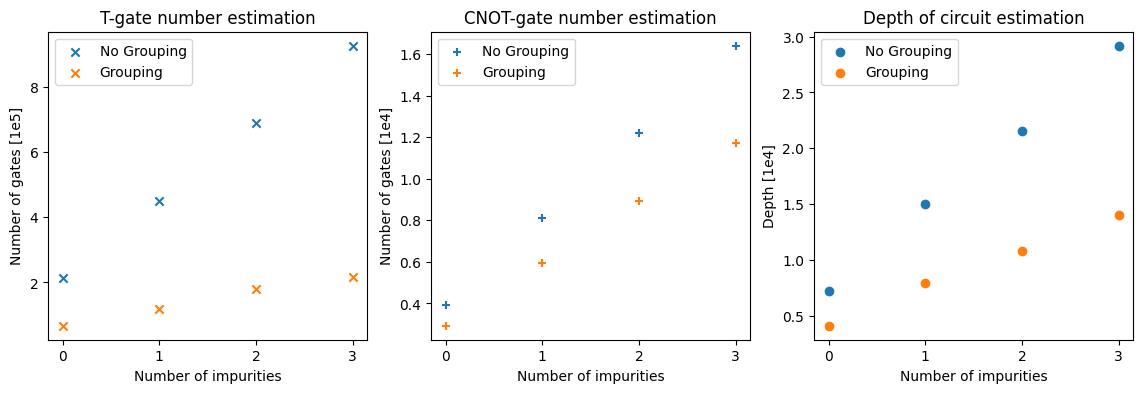

In [11]:
Hamiltonian.current_number_bosons = 3
impurities = [f"{i} impurities" for i in range(4)]
gates_group = {"T" : [], "CNOT" : []}
gates_no_group = {"T" : [], "CNOT" : []}
depth_group = []
depth_no_group = []

for i,_ in enumerate(impurities):
    if bool(i):
        Hamiltonian.add_14N_impurity([[i,i,i]])

    gates, depth = circuit_resources(H_obj = Hamiltonian, time = 1e-12, order = 2, steps = 10, grouping = False)
    gates_no_group["T"].append(gates[1]*36) # factor from formula ceil(1.149 * math.log(1 / 1e-10) + 9.2) for T gates estimations
    gates_no_group["CNOT"].append(gates[2])
    depth_no_group.append(depth)

    gates, depth = circuit_resources(H_obj = Hamiltonian, time = 1e-12, order = 2, steps = 10, grouping = True)
    gates_group["T"].append(gates[1]*36) # factor from formula ceil(1.149 * math.log(1 / 1e-10) + 9.2) for T gates estimations
    gates_group["CNOT"].append(gates[2])
    depth_group.append(depth)

    print(f"\nFinished estimations with {i} impurities.")
    print(f"Without grouping : Number of T gates = {gates_no_group['T'][i]}, Number of CNOT gates = {gates_no_group['CNOT'][i]}, Depth = {depth_no_group[i]}")
    print(f"With grouping : Number of T gates = {gates_group['T'][i]}, Number of CNOT gates = {gates_group['CNOT'][i]}, Depth = {depth_group[i]}")

# constructing image
fig, axs = plt.subplots(1, 3, figsize = (14,4))
axs[0].scatter(range(len(impurities)), 1e-5*np.array(gates_no_group["T"]), marker = "x", label = "No Grouping")
axs[0].scatter(range(len(impurities)), 1e-5*np.array(gates_group["T"]), marker = "x", label = "Grouping")
axs[1].scatter(range(len(impurities)), 1e-4*np.array(gates_no_group["CNOT"]), marker = "+", label = "No Grouping")
axs[1].scatter(range(len(impurities)), 1e-4*np.array(gates_group["CNOT"]), marker = "+", label = "Grouping")
axs[2].scatter(range(len(impurities)), 1e-4*np.array(depth_no_group), marker = "o", label = "No Grouping")
axs[2].scatter(range(len(impurities)), 1e-4*np.array(depth_group), marker = "o", label = "Grouping")
axs[0].set(xlabel = "Number of impurities", ylabel = "Number of gates [1e5]", title = "T-gate number estimation", xticks = range(len(impurities)))
axs[1].set(xlabel = "Number of impurities", ylabel = "Number of gates [1e4]", title = "CNOT-gate number estimation", xticks = range(len(impurities)))
axs[2].set(xlabel = "Number of impurities", ylabel = "Depth [1e4]", title = "Depth of circuit estimation", xticks = range(len(impurities)))
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.show()

### As the number of NV centers increases


Finished estimations with 1 NV centers.
Without grouping : Number of T gates = 212868, Number of CNOT gates = 3925, Depth = 7223
With grouping : Number of T gates = 67068, Number of CNOT gates = 2927, Depth = 4089

Finished estimations with 2 NV centers.
Without grouping : Number of T gates = 822024, Number of CNOT gates = 14729, Depth = 25233
With grouping : Number of T gates = 231264, Number of CNOT gates = 11293, Depth = 14061

Finished estimations with 3 NV centers.
Without grouping : Number of T gates = 1828260, Number of CNOT gates = 32433, Depth = 47603
With grouping : Number of T gates = 456372, Number of CNOT gates = 24649, Depth = 25040

Finished estimations with 4 NV centers.
Without grouping : Number of T gates = 3079656, Number of CNOT gates = 54197, Depth = 74983
With grouping : Number of T gates = 714744, Number of CNOT gates = 41609, Depth = 39597


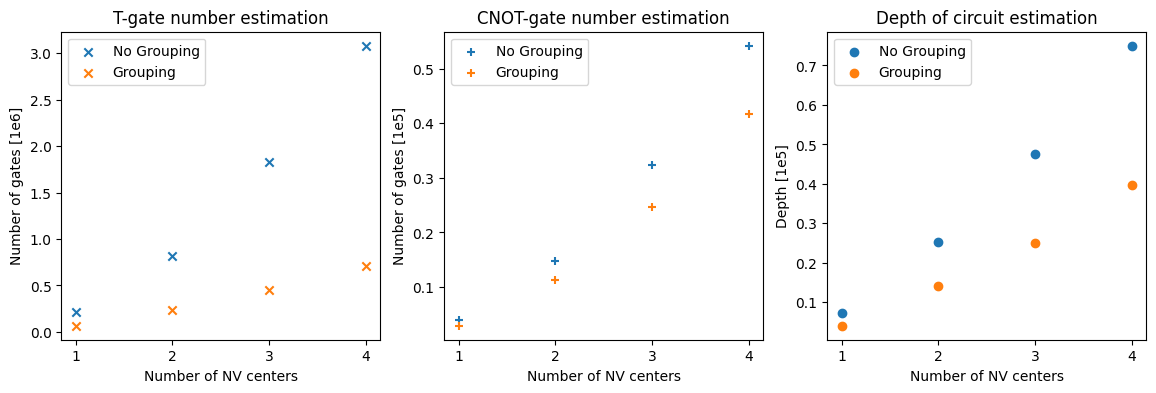

In [12]:
Hamiltonian.current_number_NV_spins = 1 # resetting hamiltonian
Hamiltonian.current_number_bosons = 3
number_nv = [f"{i+1} NV" for i in range(4)]
gates_group = {"T" : [], "CNOT" : []}
gates_no_group = {"T" : [], "CNOT" : []}
depth_group = []
depth_no_group = []

for i,_ in enumerate(number_nv):
    Hamiltonian.current_number_NV_spins = i+1
    Hamiltonian.distances_NV_spins = [[j+1,j+1,j+1] for j in range(int(0.5*(i + 1)*(i)))]

    gates, depth = circuit_resources(H_obj = Hamiltonian, time = 1e-12, order = 2, steps = 10, grouping = False)
    gates_no_group["T"].append(gates[1]*36) # factor from formula ceil(1.149 * math.log(1 / 1e-10) + 9.2) for T gates estimations
    gates_no_group["CNOT"].append(gates[2])
    depth_no_group.append(depth)

    gates, depth = circuit_resources(H_obj = Hamiltonian, time = 1e-12, order = 2, steps = 10, grouping = True)
    gates_group["T"].append(gates[1]*36) # factor from formula ceil(1.149 * math.log(1 / 1e-10) + 9.2) for T gates estimations
    gates_group["CNOT"].append(gates[2])
    depth_group.append(depth)

    print(f"\nFinished estimations with {i+1} NV centers.")
    print(f"Without grouping : Number of T gates = {gates_no_group['T'][i]}, Number of CNOT gates = {gates_no_group['CNOT'][i]}, Depth = {depth_no_group[i]}")
    print(f"With grouping : Number of T gates = {gates_group['T'][i]}, Number of CNOT gates = {gates_group['CNOT'][i]}, Depth = {depth_group[i]}")

# constructing image
fig, axs = plt.subplots(1, 3, figsize = (14,4))
axs[0].scatter(range(1,len(number_nv)+1), 1e-6*np.array(gates_no_group["T"]), marker = "x", label = "No Grouping")
axs[0].scatter(range(1,len(number_nv)+1), 1e-6*np.array(gates_group["T"]), marker = "x", label = "Grouping")
axs[1].scatter(range(1,len(number_nv)+1), 1e-5*np.array(gates_no_group["CNOT"]), marker = "+", label = "No Grouping")
axs[1].scatter(range(1,len(number_nv)+1), 1e-5*np.array(gates_group["CNOT"]), marker = "+", label = "Grouping")
axs[2].scatter(range(1,len(number_nv)+1), 1e-5*np.array(depth_no_group), marker = "o", label = "No Grouping")
axs[2].scatter(range(1,len(number_nv)+1), 1e-5*np.array(depth_group), marker = "o", label = "Grouping")
axs[0].set(xlabel = "Number of NV centers", ylabel = "Number of gates [1e6]", title = "T-gate number estimation", xticks = range(1,len(number_nv)+1))
axs[1].set(xlabel = "Number of NV centers", ylabel = "Number of gates [1e5]", title = "CNOT-gate number estimation", xticks = range(1,len(number_nv)+1))
axs[2].set(xlabel = "Number of NV centers", ylabel = "Depth [1e5]", title = "Depth of circuit estimation", xticks = range(1,len(number_nv)+1))
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.show()

### Remark and conclusions

- Compilation time of the *Resource estimations* section: ~ 6 min.
- The object `Many_NVs_Hamiltonian` provides an straighforward yet dynamical and complete way to test many configurations of this specific quantum system.
- The reduction in the number of gates and circuit's depth is significant, and it is lightweightly implemented by the `remove_adjoint_operations` decorator  to PennyLane qnodes — programmed as part of this project, and assisted by the function `H_as_comm_groups` from the `Hamiltonian` instance.

## Time evolution using Trotterization

Let's simulate the simple-model and an advanced-model time evolution up to a few picoseconds. For this section the following functions were programmed.

- `gray_to_bin`: a function to switch from gray to binary encoding, and viceversa.
- `Hamiltonian_Trotterization`: a function to implement the time evolution operator using Trotter-Suzuki product formulas. It allows to manage the order and steps of the implementation. Only even numbers for the order are admitted.

The section *Importing packages and defining useful functions* shows its straightforward use and seamlesly coupling with the other objects and optimization layer defined for this project.

In [13]:
Hamiltonian.current_number_NV_spins = 1 # resetting to the simple model

In [14]:
Trotter_error(Operator = Hamiltonian, time = 100e-12, order = 2, steps = 50) # calculating the error

0.038482659960732156

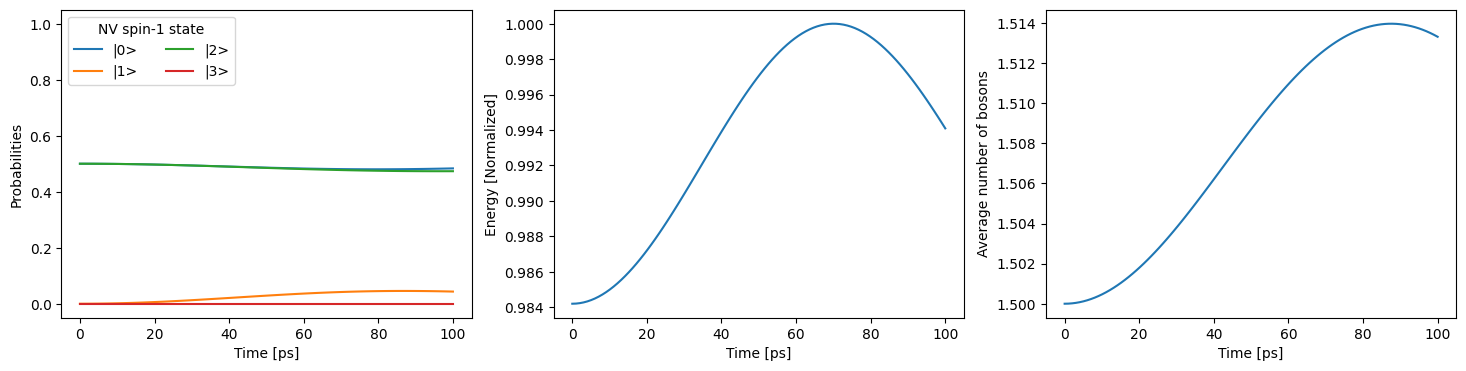

In [15]:
time = np.linspace(0,100e-12,100) # define time array
simple_model_evolution = time_evolution(H_obj = Hamiltonian, # defining function for evolving the simple model
                                        order = 2, steps = 50,
                                        spins_init_state = ["superposition"]*len(Hamiltonian.spin_wires), boson_init_state = "superposition")
nv_probs, H_expval, n_expval = simple_model_evolution(time) # time evolution using batching

# constructing picture
fig, axs = plt.subplots(1, 3, figsize = (18,4))
axs[0].plot(time*(1e12), nv_probs, label = [f"|{i}>" for i in range(4)])
axs[1].plot(time*(1e12), H_expval/np.max(H_expval)),
axs[2].plot(time*(1e12), n_expval/Hamiltonian.omega)

axs[0].set(xlabel = "Time [ps]", ylabel = "Probabilities",  ylim = [-0.05,1.05])
axs[1].set(xlabel = "Time [ps]", ylabel = "Energy [Normalized]")
axs[2].set(xlabel = "Time [ps]", ylabel = "Average number of bosons")
axs[0].legend(loc = "upper left", ncols = 2, title = "NV spin-1 state")

plt.show()

In [16]:
# defining an advanced model
Hamiltonian.current_number_NV_spins = 2
Hamiltonian.distances_NV_spins = [[1,0,1]]
Hamiltonian.current_number_bosons = 15
Hamiltonian.add_14N_impurity([[1,0,0],[0,0,-1]])

In [17]:
Trotter_error(Operator = Hamiltonian, time = 5e-12, order = 2, steps = 50)

0.06614417511243291

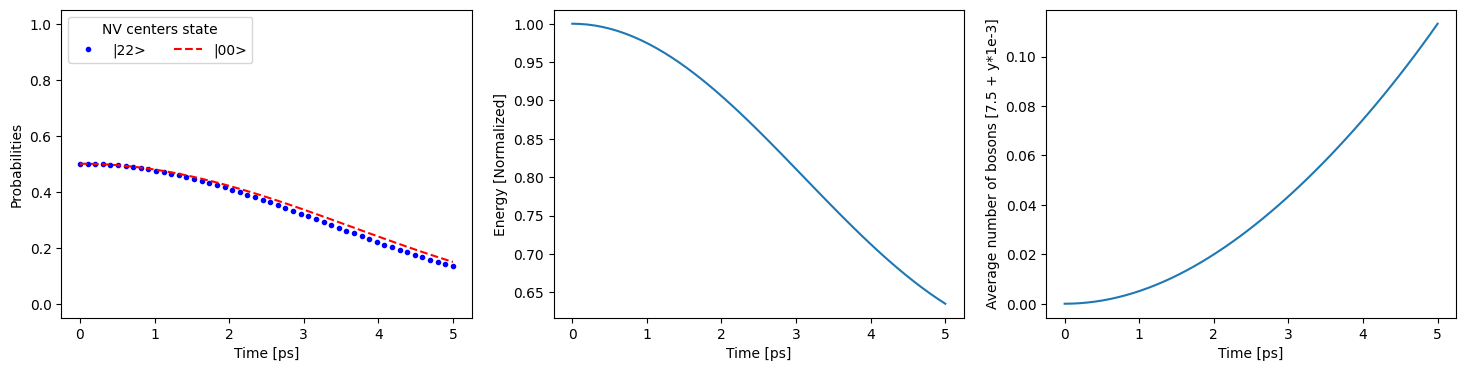

In [18]:
time = np.linspace(0,5e-12,50)
advanced_model_evolution = time_evolution(H_obj = Hamiltonian, order = 2, steps = 50, spins_init_state = "GHZ", boson_init_state = "superposition")
nv_probs, H_expval, n_expval = advanced_model_evolution(time)
fig, axs = plt.subplots(1, 3, figsize = (18,4))
axs[0].plot(time*(1e12), nv_probs[:,10], "b.", label = "|22>")
axs[0].plot(time*(1e12), nv_probs[:,0], "r--", label = "|00>")
axs[1].plot(time*(1e12), H_expval/np.max(H_expval)),
axs[2].plot(time*(1e12), 1e3*(n_expval/Hamiltonian.omega - 7.5))

axs[0].set(xlabel = "Time [ps]", ylabel = "Probabilities",  ylim = [-0.05,1.05])
axs[1].set(xlabel = "Time [ps]", ylabel = "Energy [Normalized]")
axs[2].set(xlabel = "Time [ps]", ylabel = "Average number of bosons [7.5 + y*1e-3]")
axs[0].legend(loc = "upper left", ncols = 2, title = "NV centers state")

plt.show()

### Remark and conclusions

- Compilation time of the *Time evolution using Trotterization* section : ~ 28 min
- This project provides all tools for an optimized time evolution using Trotterization. Nonetheless, reaching larger timescales requires more resources and computation time — as expected.
- A simple but significant check mark is that the $|3\rangle$ state in the simple model evolution does never change, i.e. the probability of measuring it is always zero. This stems from the fact that this state is never used when encoding spin-1 states into 2-qubit states. Hence, we will never measure an electronic nor nuclear state in the $|3\rangle$, as expected.

## Fast-forwarding for large timescales

Reaching large timescales — such as the microseconds — just by using Trotterization is a difficult problem. But the theory tells us that important time measurements, like coherence times, are in these timescales.

Here is where hybrid algorithms come to help. For this project, we used a Krylov fast-forwarding algorithm to calculate a reduced Hamiltonian which dimentions are far lesser than the original Hilbert space. Then one must solve a reduced Schrodinger equation classically; Runge-kutta and matrix-exponentiating approximation methods are commonly selected.

Let's use our simple model to extract the time evolution of the autocorrelation function; this is, given the initial state $|\psi_{0}\rangle$ and its time-evolved state $|\psi(t)\rangle$, we are going to calculate the number $C^{2}(t) = |\langle \psi_{0}| \psi(t)\rangle|^{2}$. This function can be — roughly — understood as how probable is to measure the initial state at the time $t$. If the initial state of the NV spin-1 is $|2\rangle$, then when this function reaches zero we would have an insight onto the time it took for the system to return to its ground state, i.e. $|0\rangle$.

This algorithm is based on evolving the system up to small times, then providing an approximation for the time evolution up to arbitrary times. The trick is to approximate the time evolution by trotterization up to times where trotter error is still small. Better approximations require adding more reference states.

In [19]:
Hamiltonian.current_number_NV_spins = 1 # resetting system
Hamiltonian.current_number_bosons = 3
Hamiltonian.info_wires # checking wires

(5, 6, [0, 1, 2, 3, 4, 5])

We begin by defining an instance of `KFF`, a class containing many functions used previously and modifications of those, for a straighforward use of the Krylov Fast-Forwarding algorithm. Here is a quick explanation of its inputs:

- `H_obj`: instance from `Many_NVs_Hamiltonian`.
- `dim_M`: dimension of the Krylov subspace.
- `trotter_order`: order of trotterization.
- `tau`: tau parameter of Krylov algorithm.
- `initial_state`: initial states of NV spins and bosons. The state of the spins is a list of strings "zero", "excited", "superposition", or a single string "GHZ". States of bosons can be "superposition" or a bitstring.
- `accuracy`: threshold for stopping criteria based on the difference between the autocorrelations from different subspace matrices containing more reference states.
- `max_number_steps`: maximum number of steps in the trotterization.
- `device`: PennyLane device where time evolution by trotterization is implemented.

In [20]:
KFF_simple_model = KFF(Hamiltonian,
                       dim_M = 5,
                       trotter_order = 2,
                       tau = 20e-12,
                       initial_state = [["excited"], "superposition"],
                       accuracy = 1e-6,
                       max_number_steps = 50,
                       device = "lightning.qubit")

Trotter error for 1 step of a 2th order Trotterization until time 2e-11: 0.7696531992650332


Our total evolution time will be `dim_M` * `tau` = 100 ps, then the Trotter error is:

In [21]:
Trotter_error(Operator = Hamiltonian, time = 100e-12, order = 2, steps = 50) # total evolution time = 100 ps

0.038482659960732156

Then, our approximation is good.

We will have up to 4 reference states, including the initial one with $|2\rangle$ being the initial state of our NV center. Let's evolve it up to 100 nanoseconds and use an implemented matrix-emponentiating method to solve the differential equation.

Calculating S and H matrices by adding the following block-matrices associated with reference states (r1,r2) :
[(0, 0)]
Solving differential equation system utilizing exact evolution with time step : 5e-10
New reference added : 100000
Calculating S and H matrices by adding the following block-matrices associated with reference states (r1,r2) :
[(0, 1), (1, 1)]
Solving differential equation system utilizing exact evolution with time step : 5e-10
New reference added : 100011
Calculating S and H matrices by adding the following block-matrices associated with reference states (r1,r2) :
[(0, 2), (1, 2), (2, 2)]
Solving differential equation system utilizing exact evolution with time step : 5e-10
New reference added : 100001
Calculating S and H matrices by adding the following block-matrices associated with reference states (r1,r2) :
[(0, 3), (1, 3), (2, 3), (3, 3)]
Solving differential equation system utilizing exact evolution with time step : 5e-10


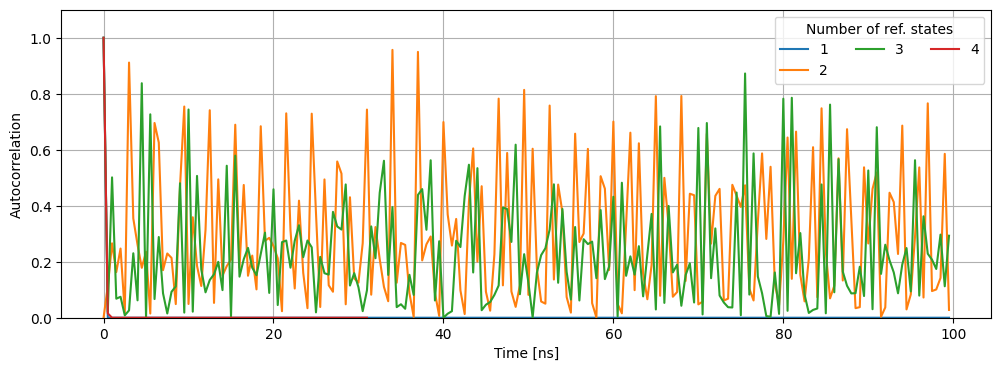

In [23]:
fig, axs = plt.subplots(1,1, figsize = (12,4))

for i in range(4):
    if i==0:
        restart_algorithm = True
    else:
        restart_algorithm = False
    time, autocorrelation = KFF_simple_model.run_one_algorithm_step(end_time = 100e-9, # simulate up to this time
                                                                    number_references_added = 1, # number of reference states to be added each KFF rerun
                                                                    restart_algorithm = restart_algorithm, # whether or not to reestar the reference state pool
                                                                    use_RK4 = False, # use RK4 method
                                                                    dt_for_exp = 0.5e-9, # timestep if using exponentiation method, i.e. use_RK4 = False
                                                                    device = "lightning.qubit", # device where the circuit to add reference states is run
                                                                    shots = 15000, # shots of the device
                                                                    precision = 1e-11) # using SVD for matrix invertions, this is the threshold for the singular values
    axs.plot((1e9)*time, np.array([np.abs(corr)**2 for corr in autocorrelation]), label = f"{len(KFF_simple_model.reference_states)}")

axs.set_ylim([0,1.1])
axs.set_ylabel("Autocorrelation")
axs.set_xlabel("Time [ns]")
axs.legend(loc = "upper right", title = "Number of ref. states", ncols = 3)
axs.grid()

plt.show()

### Remarks and conclusions

- Compilation time for the *Fast-forwarding for large timescales* section: ~ 20 min.
- Notice that for 2 and 3 reference states, the algorithm returns the time evolution of the autocorrelation function. Nevertheless, we are currently dealing with inestability problems when inverting, exponentiating, and multiplying matrices several times, these problems result in incorrect approximations to the autocorrelation functions for 1 and 4 reference states. This also depends on the reference state added to the pool of reference states.
- We expect to solve and deliver an fully functional way to implement this fast-forwarding technique, even thinking about implementing a variational approach.
- Were this function to work properly, the results would help researchers to simulate several modifications and settings of the NV centre system up to the microsecond timescale.

# A personal note

This project provided a valuable opportunity to contribute to the implementation of quantum solutions for real-world challenges — in this case by simulating quantum systems to enhance their modeling and analysis. I am truly grateful to have been part of this experience, and I sincerely look forward — in the best case scenario — to work with the QSL, exploring and developing quantum-based approaches to address complex, real-world problems.